In [1]:
%matplotlib inline
import emcee
import numpy as np
import matplotlib.pyplot as plt
import os, sys, time, math
import torch
from tqdm import tqdm
from torch.multiprocessing import Pool#, set_start_method
from getdist import plots, MCSamples
import pymultinest
import getdist

sys.path.append('/home/joeadamo/Research') #<- parent directory of dark emulator code
from DarkEmuPowerRSD import pkmu_nn, pkmu_hod
from CovNet import CovNet

In [2]:
plt.rcParams['figure.facecolor'] = 'white'

In [3]:
training_dir = "/home/joeadamo/Research/CovNet/Data/Training-Set-NG/"
data_dir =  "/home/joeadamo/Research/CovNet/Data/"
PCA_dir = "/home/joeadamo/Research/CovNet/Data/PCA-Set/"
CovaPT_dir = "/home/joeadamo/Research/CovaPT/Example-Data/"

In [4]:
cosmo_prior = np.array([[66.5, 75.5],
                        [0.10782, 0.13178],
                        [0.0211375, 0.0233625],
                        [1.1885e-9, 2.031e-9],#[2.4752, 3.7128],
                        [1.806, 2.04],
                        [-2.962, 0.458]])

cosmo_fid = np.array([67.8,0.1190,0.02215,2.207e-9,1.9485,-0.5387])
print((cosmo_fid[1] + cosmo_fid[2] + 0.00064) / (cosmo_fid[0]/100.)**2)

gparams = {'logMmin': 13.9383, 'sigma_sq': 0.7918725**2, 'logM1': 14.4857, 'alpha': 1.19196,  'kappa': 0.600692, 
          'poff': 0.0, 'Roff': 2.0, 'alpha_inc': 0., 'logM_inc': 0., 'cM_fac': 1., 'sigv_fac': 1., 'P_shot': 0.}
redshift = 0.5

0.3084510228765848


In [5]:
# load in the mcmc chain from file
N    = 60000
NDIM = 6
#file1 = np.load(data_dir+"mcmc_chains_fixed.npz")
file2 = np.load(data_dir+"mcmc_chains_full.npz")
#chain_T0 = file1["chain"]
chain_full = file2["chain"]
#rate_fixed = file1["rate"]
rate_full = file2["rate"]

In [6]:
# fig, ax = plt.subplots(NDIM,1,figsize=(10, 2.5 * NDIM))
# for i in range(NDIM):
#     ax[i].plot(chain_T0[:,i].T, 'k-', lw=0.3)
# plt.show()  

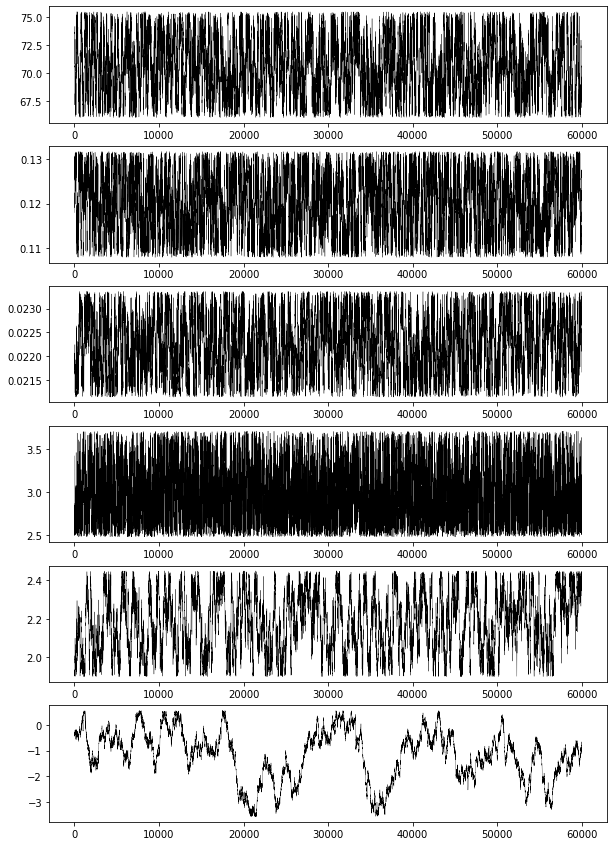

In [7]:
fig, ax = plt.subplots(NDIM,1,figsize=(10, 2.5 * NDIM))
for i in range(NDIM):
    ax[i].plot(chain_full[:,i].T, 'k-', lw=0.3)
plt.show()  

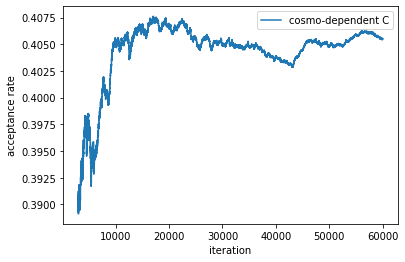

In [8]:
#plt.plot(range(N)[3000:], rate_fixed[3000:], label="fixed C")
plt.plot(range(N)[3000:], rate_full[3000:], label="cosmo-dependent C")
plt.xlabel("iteration")
plt.ylabel("acceptance rate")
plt.legend()

In [9]:
N_BURN_IN = 3000

#samples_fixed = chain_T0[N_BURN_IN:, :].reshape((-1,NDIM))
samples_full = chain_full[N_BURN_IN:, :].reshape((-1,NDIM))

In [10]:
def plot_cosmo_contours(sample_list_1, sample_list_2, legend_labels, num_plots):
    names = ['H0', 'omegac', 'omegab', 'As', 'b1', 'b2']
    labels =  ["H_0", '\omega_c', '\omega_b', 'A_s', 'b1', 'b2']
    
    #cosmo_truth = [69., 0.1199772, 0.0228528, 2e-9, 1.9485, -0.5386]
    cosmo_truth = [67.8, 0.1190, 0.02215, 2.207e-9, 2.01, -0.47]
    truth_dict = {}
    for name, truth in zip(names, cosmo_truth):
        truth_dict[name] = truth
        
    getdist_samples_1, getdist_samples_2 = [],[]
    label = labels[:num_plots]
    name = names[:num_plots]
    getdist_samples_1 = MCSamples(samples=sample_list_1[:,:num_plots], names = name, labels=label, label=legend_labels[0])
    getdist_samples_2 = MCSamples(samples=sample_list_2[:,:num_plots], names = name, labels=label, label=legend_labels[1])
    
    g = plots.get_subplot_plotter()
    g.triangle_plot([getdist_samples_1, getdist_samples_2], filled=True, markers=truth_dict)
    
    plt.show()

Removed no burn in
Removed no burn in


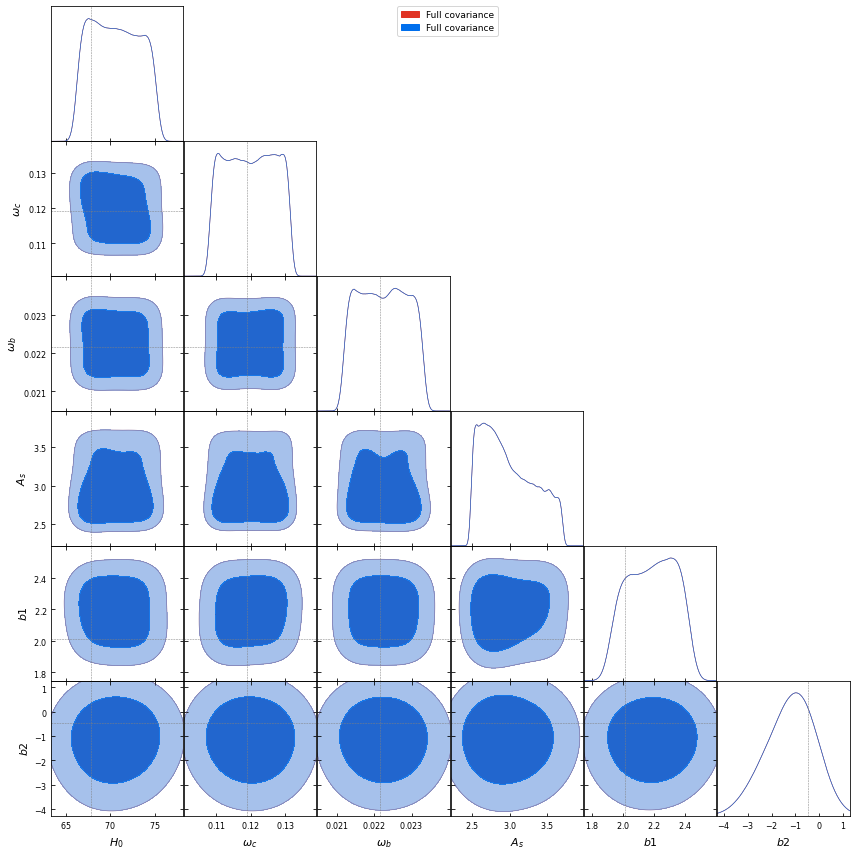

In [11]:
plot_cosmo_contours(samples_full, samples_full, ['Full covariance', "Full covariance"], 6)

## MultiNest Code

  analysing data from /home/joeadamo/Research/CovNet/chains/T0-.txt
  analysing data from /home/joeadamo/Research/CovNet/chains/No-T0-.txt


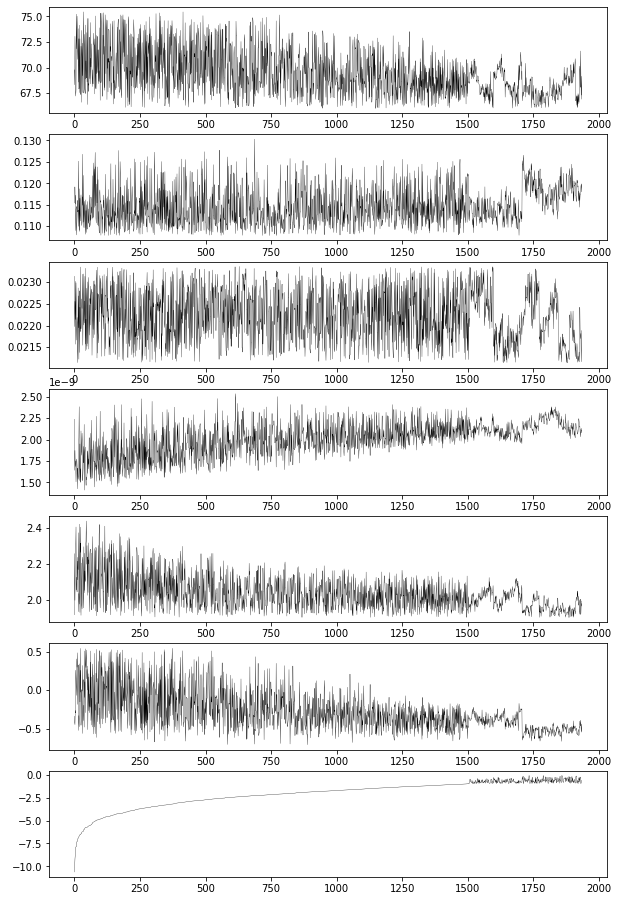

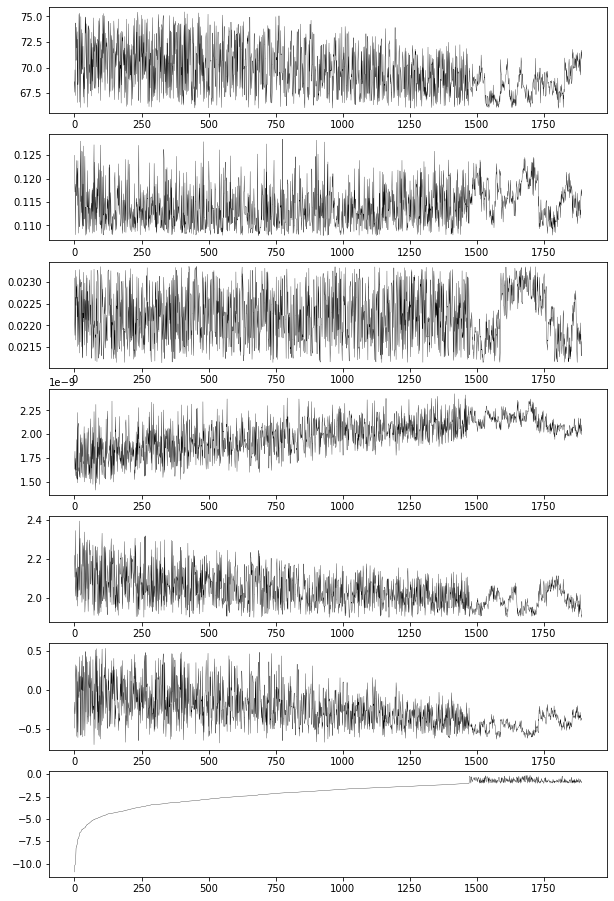

In [14]:
#import pymultinest
chains_dir = "/home/joeadamo/Research/CovNet/chains/"
prefix = ["T0-", "No-T0-"]
parameters = ["H0", "omch2","ombh2", "As","b1","b2"]
n_params=6
# lets analyse the results
a_T0 = pymultinest.Analyzer(n_params = n_params, outputfiles_basename=chains_dir+prefix[0])
a_no_T0 = pymultinest.Analyzer(n_params = n_params, outputfiles_basename=chains_dir+prefix[1])
#s = a.get_stats()

# This takes the end of the chain calculated by multinest
chain_T0 = a_T0.get_equal_weighted_posterior()
chain_no_T0 = a_no_T0.get_equal_weighted_posterior()

chain_T0[:,3] = np.exp(chain_T0[:,3]) / 1e10
chain_no_T0[:,3] = np.exp(chain_no_T0[:,3]) / 1e10
fig, ax = plt.subplots(NDIM+1,1,figsize=(10, 2.5 * NDIM+1))
for i in range(7):
    ax[i].plot(chain_T0[:,i], 'k-', lw=0.3)
fig, ax = plt.subplots(NDIM+1,1,figsize=(10, 2.5 * NDIM+1))
for i in range(7):
    ax[i].plot(chain_no_T0[:,i], 'k-', lw=0.3)
plt.show()

Removed no burn in
Removed no burn in


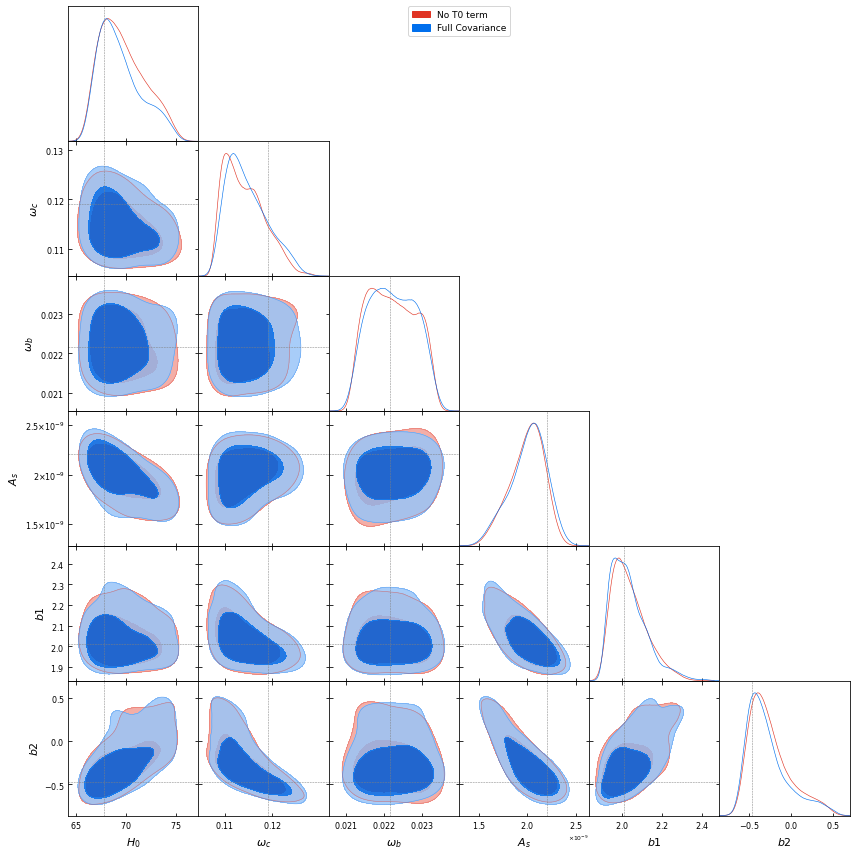

In [16]:
N_BURN_IN = 10
cosmo_truth = [67.8,0.1190,0.02215,3.094,1.9485,-0.538]
cosmo_fid = np.array([67.8,0.1190,0.02215,3.094,1.9485,-0.5387])
Omega_b = 0.048206; h = cosmo_fid[0] / 100.
Omega_m = 0.307115
#model the cholesky decomposition
#double check how I canclulate H0
#compare C with other emulators
#samples_fixed = chain_T0[N_BURN_IN:, :].reshape((-1,NDIM))
# look into what the consensus is for using the T0 term <- can look at this in the simulation case as well
samples_1 = chain_T0[N_BURN_IN:, :NDIM].reshape((-1,NDIM))
samples_2 = chain_no_T0[N_BURN_IN:, :NDIM].reshape((-1,NDIM))
plot_cosmo_contours(samples_2, samples_1, [ "No T0 term", 'Full Covariance'], 6)
#plot_cosmo_contours(samples_2, samples_2, [ "No T0 term", "No T0 term"], 6

In [17]:
print("\tFull Covariance\t\t\tNo T0")

print(str(parameters[0])+":\t {:0.2f} +- {:0.2f}\t\t\t {:0.2f} +- {:0.2f}".format(np.mean(chain_T0[:,0]), np.std(chain_T0[:,0]), np.mean(chain_no_T0[:,0]), np.std(chain_no_T0[:,0])))
print(str(parameters[1])+":\t {:0.4f} +- {:0.4f}\t\t {:0.4f} +- {:0.4f}".format(np.mean(chain_T0[:,1]), np.std(chain_T0[:,1]), np.mean(chain_no_T0[:,1]), np.std(chain_no_T0[:,1])))
print(str(parameters[2])+":\t {:0.5f} +- {:0.5f}\t\t {:0.5f} +- {:0.5f}".format(np.mean(chain_T0[:,2]), np.std(chain_T0[:,2]), np.mean(chain_no_T0[:,2]), np.std(chain_no_T0[:,2])))
print(str(parameters[3])+":\t {:0.2e} +- {:0.2e}\t\t {:0.2e} +- {:0.2e}".format(np.mean(chain_T0[:,3]), np.std(chain_T0[:,3]), np.mean(chain_no_T0[:,3]), np.std(chain_no_T0[:,3])))
print(str(parameters[4])+":\t {:0.3f} +- {:0.2f}\t\t\t {:0.3f} +- {:0.3f}".format(np.mean(chain_T0[:,4]), np.std(chain_T0[:,4]), np.mean(chain_no_T0[:,4]), np.std(chain_no_T0[:,4])))
print(str(parameters[5])+":\t {:0.3f} +- {:0.2f}\t\t\t {:0.3f} +- {:0.3f}".format(np.mean(chain_T0[:,5]), np.std(chain_T0[:,5]), np.mean(chain_no_T0[:,5]), np.std(chain_no_T0[:,5])))

for i in range(6):
    print("shift: {:0.3f} sigma".format((abs(np.mean(chain_T0[:,i]) - np.mean(chain_no_T0[:,i])) / np.std(chain_T0[:,i]))))

	Full Covariance			No T0
H0:	 69.39 +- 2.22			 69.65 +- 2.28
omch2:	 0.1147 +- 0.0044		 0.1142 +- 0.0043
ombh2:	 0.02223 +- 0.00060		 0.02221 +- 0.00061
As:	 2.01e-09 +- 1.95e-10		 1.99e-09 +- 1.83e-10
b1:	 2.032 +- 0.09			 2.035 +- 0.088
b2:	 -0.286 +- 0.26			 -0.261 +- 0.251
shift: 0.117 sigma
shift: 0.122 sigma
shift: 0.028 sigma
shift: 0.076 sigma
shift: 0.030 sigma
shift: 0.098 sigma


## Figure of Merit Code  

In [ ]:
chain_no_T0_full = np.loadtxt(chains_dir + prefix[1] + ".txt")
#chain_no_T0_full = chain_no_T0_full[1000:, 2:4]

chain_1 = chain_full[N_BURN_IN:, 0:2]
#chain_1 = chain_no_T0_full[1000:, 2:4]
print(chain_1.shape)

num_bins = 15
FoM = np.zeros(num_bins)
chain_len = chain_1.shape[0]
print(chain_len)
for b in range(num_bins):
    idx = b*int(chain_len / num_bins)
    subchain = chain_1[b*int(chain_len / num_bins):(b+1)*int(chain_len / num_bins), :]
    
    # calculate the covariance matrix of this subchain
    cov = np.cov(subchain, rowvar=False)
    FoM[b] = np.sqrt(np.linalg.det(np.linalg.inv(cov)))
    print(FoM[b])

# Calculate the FoM for the last 30% of the chain
cov = np.cov(chain_1[int(0.7*chain_len):,:], rowvar=False)
FoM_30 = np.sqrt(np.linalg.det(np.linalg.inv(cov)))

In [ ]:
plt.plot(range(num_bins), FoM)
plt.axhline(FoM_30, color="black", ls="--")
plt.axhline(FoM_30*1.1, c="grey", ls="--")
plt.axhline(FoM_30*0.9, c="grey", ls="--")
plt.text(0,FoM_30*1.11,r'(last 30%%)%.2f$\pm$10%%'%FoM_30)
plt.yscale("log")
plt.xlabel("bin")
plt.ylabel("FoM")